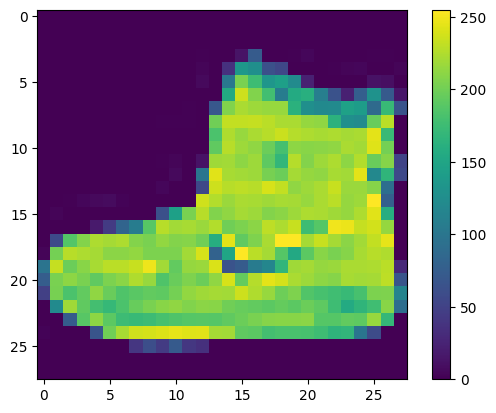

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

train_images = train_images / 255.0

test_images = test_images / 255.0

In [2]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    n_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
    for i in range(n_layers):
        model.add(tf.keras.layers.Dense(units=448*(n_layers-i),activation='relu'))

    model.add(tf.keras.layers.Dropout(hp.Choice('dropout', values=[0.1,0.2,0.4])))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 2e-4, 3e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='my_dir',
    project_name='fashion_mnist'
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

tuner.search(train_images, train_labels, epochs=400, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal num layers: {best_hps.get('num_layers')}, Optimal learning_rate: {best_hps.get('learning_rate')}, Optimal dropout: {best_hps.get('dropout')}")

Trial 10 Complete [00h 07m 24s]
val_accuracy: 0.9006666541099548

Best val_accuracy So Far: 0.9014999866485596
Total elapsed time: 00h 58m 53s
Optimal num layers: 3, Optimal learning_rate: 0.0002, Optimal dropout: 0.1


In [4]:
model = tuner.hypermodel.build(best_hps)

model.fit(train_images, train_labels, epochs=400, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/400
750/750 [==============================] - 35s 44ms/step - loss: 0.5028 - accuracy: 0.8239 - val_loss: 0.4017 - val_accuracy: 0.8556
Epoch 2/400
750/750 [==============================] - 32s 43ms/step - loss: 0.3537 - accuracy: 0.8692 - val_loss: 0.3389 - val_accuracy: 0.8787
Epoch 3/400
750/750 [==============================] - 32s 43ms/step - loss: 0.3123 - accuracy: 0.8849 - val_loss: 0.3507 - val_accuracy: 0.8738
Epoch 4/400
750/750 [==============================] - 33s 44ms/step - loss: 0.2858 - accuracy: 0.8938 - val_loss: 0.3511 - val_accuracy: 0.8738
Epoch 5/400
750/750 [==============================] - 33s 44ms/step - loss: 0.2620 - accuracy: 0.9035 - val_loss: 0.3254 - val_accuracy: 0.8794
Epoch 6/400
750/750 [==============================] - 32s 43ms/step - loss: 0.2420 - accuracy: 0.9097 - val_loss: 0.2971 - val_accuracy: 0.8925
Epoch 7/400
750/750 [==============================] - 33s 44ms/step - loss: 0.2246 - accuracy: 0.9154 - val_loss: 0.3092 - val_ac

In [5]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.4], 'ordered': True}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0002, 0.0003], 'ordered': True}


313/313 - 2s - loss: 0.4152 - accuracy: 0.8948 - 2s/epoch - 8ms/step

Test accuracy: 0.8948000073432922
313/313 [==============================] - 3s 8ms/step


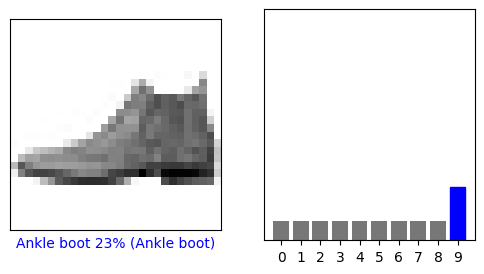

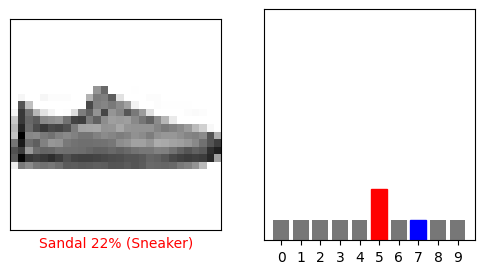

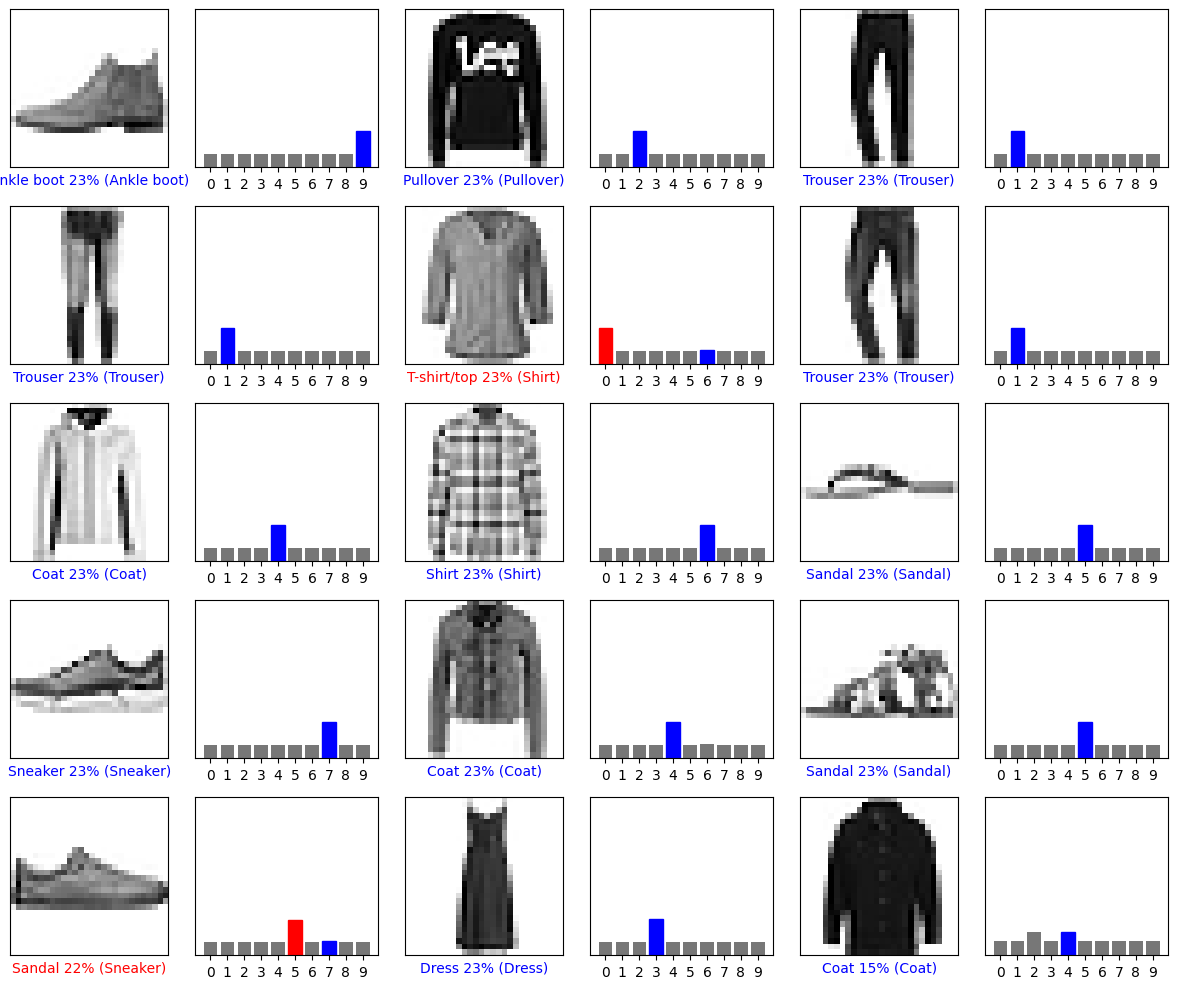

(28, 28)
(1, 28, 28)
1/1 [==============================] - 0s 49ms/step
[[0.08534069 0.08534012 0.23191573 0.08534012 0.08535434 0.08534012
  0.08534844 0.08534012 0.08534012 0.08534012]]


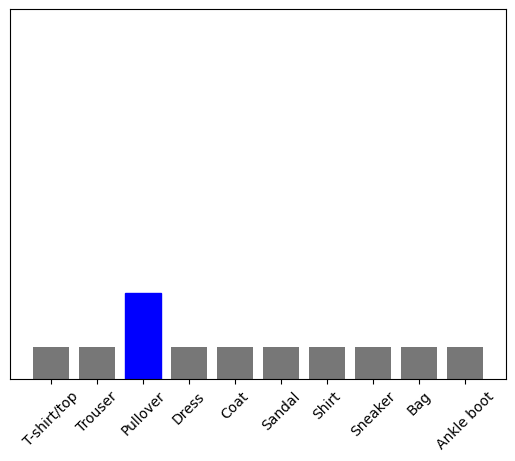

2

In [6]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)

predictions[0]

np.argmax(predictions[0])

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

predictions_single = probability_model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

np.argmax(predictions_single[0])